In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import MultipleLocator
import seaborn as sns; sns.set()
sns.__version__

'0.11.1'

In [2]:
sns.set_style("ticks", {"xtick.major.size":15,"ytick.major.size":15})

plt.rc('font', family='Helvetica')
plt.rcParams['pdf.fonttype'] = 42

%config InlineBackend.figure_format = 'retina'

In [3]:
df_pair_1985_2009 = pd.read_pickle("/data/interdisciplinarity/df_pair_1985_2009.pkl")
df_grant_1985_2009 = pd.read_pickle("/data/interdisciplinarity/df_grant_1985_2009.pkl")

In [4]:
# Source: http://www.cookbook-r.com/Graphs/Plotting_means_and_error_bars_%28ggplot2%29/
# Produces count, mean, standard deviation, standard error of the mean, and confidence interval (default 95%).
##   data: a data frame
##   measurevar: the name of a column that contains the variable to be summariezed
##   groupvars: a vector containing names of columns that contain grouping variables
##   conf_interval: the percent range of the confidence interval (default is 95%)

import scipy as sp
from scipy.stats import t

def summarySE(data, measurevar, groupvars, conf_interval=0.95):
    def std(s):
        return np.std(s, ddof=1)
    def stde(s):
        return std(s) / np.sqrt(len(s))
    def ci(s):
        # Confidence interval multiplier for standard error
        # Calculate t-statistic for confidence interval: 
        # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
        ciMult = t.ppf(conf_interval/2.0 + .5, len(s)-1)
        return stde(s)*ciMult
    def ciUpper(s):
        return np.mean(s)+ci(s)
    def ciLower(s):
        return np.mean(s)-ci(s)
    
    data = data[groupvars+measurevar].groupby(groupvars).agg([len, np.mean, std, stde, ciUpper, ciLower, ci])

    data.reset_index(inplace=True)

    data.columns = groupvars+['_'.join(col).strip() for col in data.columns.values[len(groupvars):]]

    return data

In [5]:
#####----- A -----#####
df_tmp = df_grant_1985_2009[['grant_id','num_paper','grant_interdisciplinarity_interval','funding_usd_interval']].drop_duplicates()
numPaper_per_grantITD_funding = summarySE(df_tmp, ['num_paper'], 
                                          ['grant_interdisciplinarity_interval', 'funding_usd_interval'])

In [6]:
#####----- B -----#####
df_tmp = df_pair_1985_2009[['c_hit_rate_5_lvl-0','grant_interdisciplinarity_interval','funding_usd_interval']]
hitRate_per_grantITD_funding = summarySE(df_tmp, ['c_hit_rate_5_lvl-0'], 
                                         ['grant_interdisciplinarity_interval','funding_usd_interval'])

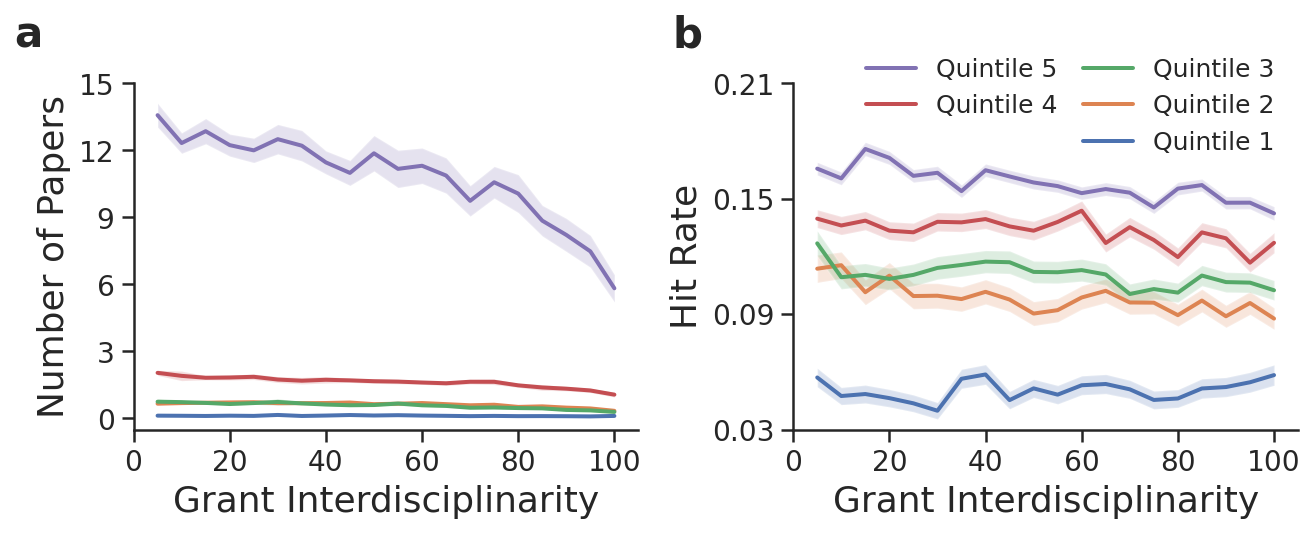

In [9]:
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(figsize=(14*(2/3),4))
gs = GridSpec(1, 2, figure=fig)

#####----- A -----#####
ax = fig.add_subplot(gs[0,0])

tmp_x = []
tmp_mu = []
tmp_ci = []
for i in range(20,101,20):
    tmp_x.append(numPaper_per_grantITD_funding[numPaper_per_grantITD_funding['funding_usd_interval']==i]['grant_interdisciplinarity_interval'])
    tmp_mu.append(numPaper_per_grantITD_funding[numPaper_per_grantITD_funding['funding_usd_interval']==i]['num_paper_mean'])
    tmp_ci.append(numPaper_per_grantITD_funding[numPaper_per_grantITD_funding['funding_usd_interval']==i]['num_paper_ci'])

for i in range(0,5):
    ax.plot(tmp_x[i], tmp_mu[i], lw=2, label='Quintile {}'.format(i+1))
    ax.fill_between(tmp_x[i], tmp_mu[i]+tmp_ci[i], tmp_mu[i]-tmp_ci[i],
                    facecolor='C{}'.format(i), alpha=0.2)

ax.set_xlabel('Grant Interdisciplinarity', fontsize=18)
ax.set_ylabel('Number of Papers', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.gca().xaxis.set_major_locator(MultipleLocator(20))
plt.xlim(0, 105)
plt.gca().yaxis.set_major_locator(MultipleLocator(3))
plt.ylim(-0.5, 15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.18, 1.2, 'a', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####----- B -----#####
ax = fig.add_subplot(gs[0,1])

tmp_x = []
tmp_mu = []
tmp_ci = []
for i in range(20,101,20):
    tmp_x.append(hitRate_per_grantITD_funding[hitRate_per_grantITD_funding['funding_usd_interval']==i]['grant_interdisciplinarity_interval'])
    tmp_mu.append(hitRate_per_grantITD_funding[hitRate_per_grantITD_funding['funding_usd_interval']==i]['c_hit_rate_5_lvl-0_mean'])
    tmp_ci.append(hitRate_per_grantITD_funding[hitRate_per_grantITD_funding['funding_usd_interval']==i]['c_hit_rate_5_lvl-0_ci'])

for i in range(0,5):
    ax.plot(tmp_x[i], tmp_mu[i], lw=2, label='Quintile {}'.format(i+1))
    ax.fill_between(tmp_x[i], tmp_mu[i]+tmp_ci[i], tmp_mu[i]-tmp_ci[i],
                    facecolor='C{}'.format(i), alpha=0.2)

ax.set_xlabel('Grant Interdisciplinarity', fontsize=18)
ax.set_ylabel('Hit Rate', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.gca().xaxis.set_major_locator(MultipleLocator(20))
plt.xlim(0, 105)
plt.yticks([0.03, 0.09, 0.15, 0.21])
ax.set_yticklabels(['0.03', '0.09', '0.15', '0.21'])
plt.ylim(0.03, 0.21)

handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0], reverse=True))
h = list(handles)
h.insert(2, plt.plot([], [], color=(0,0,0,0), label=' ')[0])
l = list(labels)
l.insert(2, '')
ax.legend(h, l, loc='lower left', bbox_to_anchor=(0.1, 0.73),
          fontsize=12.5, frameon=False, ncol=2, columnspacing=1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.18, 1.2, 'b', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####-------------#####
plt.tight_layout()
plt.show()

fig.savefig('./fig/supp_funding-size_grant-impact.pdf', format='pdf', dpi=700, bbox_inches='tight')